# Tuning hyperparameters and model architecture

----

> This section will have many models and in each iteration, we will change different parameters and architectures to finally arrive at the best models.

### Importing the libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../helpers/')
from plot_graphs import plot_loss, plot_acc

### Setting batch and image size, and importing the datasets 

In [3]:
# Batch and image sizes
IMAGE_SIZE = 100
BATCH_SIZE = 32

# Getting the train, test and validation data
train = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/train", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

# Caching the data for faster loading
train = train.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val = val.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test = test.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Found 3840 files belonging to 6 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 480 files belonging to 6 classes.
Found 480 files belonging to 6 classes.


2022-08-30 07:09:09.458883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-30 07:09:09.459024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 1. Finding ideal model architecture, dropout rate, and no. of epochs

> The purpose of this section is to identify the ideal model architecture (no. of layers and sizes of those layers), and also the ideal dropout rate and no. of epochs.

### Adding more layers than baseline model with larger layer size

In [4]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_1_1 = keras.Model(inputs, outputs)

model_1_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1_1.summary()

history_1_1 = model_1_1.fit(
  train,
  epochs=25,
  validation_data=val
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                         

2022-08-29 01:28:58.291947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-29 01:28:58.292054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.6876 - accuracy: 0.2883

2022-08-29 01:29:03.947858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 6s 46ms/step - loss: 1.6876 - accuracy: 0.2883 - val_loss: 1.3303 - val_accuracy: 0.5208
Epoch 2/25
120/120 [==============================] - 5s 43ms/step - loss: 1.3415 - accuracy: 0.4667 - val_loss: 1.1628 - val_accuracy: 0.5625
Epoch 3/25
120/120 [==============================] - 5s 42ms/step - loss: 1.1519 - accuracy: 0.5531 - val_loss: 1.0342 - val_accuracy: 0.6104
Epoch 4/25
120/120 [==============================] - 5s 43ms/step - loss: 1.0114 - accuracy: 0.6203 - val_loss: 0.8923 - val_accuracy: 0.6750
Epoch 5/25
120/120 [==============================] - 5s 43ms/step - loss: 0.8836 - accuracy: 0.6685 - val_loss: 0.7515 - val_accuracy: 0.7396
Epoch 6/25
120/120 [==============================] - 5s 42ms/step - loss: 0.7701 - accuracy: 0.7224 - val_loss: 0.6223 - val_accuracy: 0.7854
Epoch 7/25
120/120 [==============================] - 5s 42ms/step - loss: 0.6698 - accuracy: 0.7648 - val_loss: 0.5715 - val_accuracy: 0.8021
Epoch 8/25

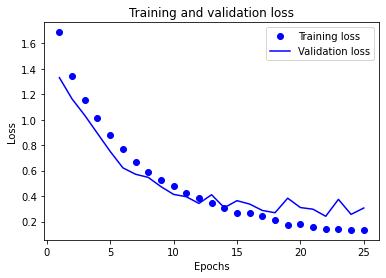

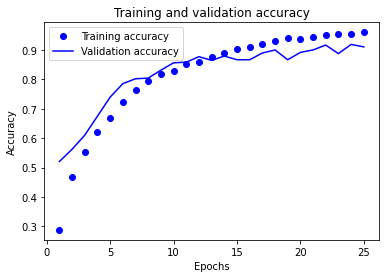

In [5]:
plot_loss(history_1_1)
plot_acc(history_1_1)

> This model trained quite well with validation accuracies reaching 91% towards the end, but perhaps adding more layers can improve it.

---

*Highest Observed Validation Accuracy*: **91.88%**

---

### Ideal no. of layers (and layer size) as well as dropout rate and epochs

> In this model, after various experiments, the final model architecture is used with dropout rate of 0.5 and trained for 30 epochs

In [38]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_1_2 = keras.Model(inputs, outputs)

model_1_2.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1_2.summary()

history_1_2 = model_1_2.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_27 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_251 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_252 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 conv2d_253 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                          

2022-08-31 00:37:08.216913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.2247

2022-08-31 00:37:20.397530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 13s 94ms/step - loss: 1.8252 - accuracy: 0.2247 - val_loss: 1.5828 - val_accuracy: 0.3333
Epoch 2/30
120/120 [==============================] - 11s 90ms/step - loss: 1.4439 - accuracy: 0.4495 - val_loss: 1.2477 - val_accuracy: 0.5688
Epoch 3/30
120/120 [==============================] - 11s 90ms/step - loss: 0.9241 - accuracy: 0.6656 - val_loss: 0.6627 - val_accuracy: 0.7604
Epoch 4/30
120/120 [==============================] - 11s 91ms/step - loss: 0.6287 - accuracy: 0.7846 - val_loss: 0.4020 - val_accuracy: 0.8854
Epoch 5/30
120/120 [==============================] - 11s 92ms/step - loss: 0.4537 - accuracy: 0.8456 - val_loss: 0.3038 - val_accuracy: 0.8958
Epoch 6/30
120/120 [==============================] - 11s 93ms/step - loss: 0.3118 - accuracy: 0.8943 - val_loss: 0.2603 - val_accuracy: 0.9167
Epoch 7/30
120/120 [==============================] - 11s 94ms/step - loss: 0.2411 - accuracy: 0.9263 - val_loss: 0.2956 - val_accuracy: 0.9083
Epo

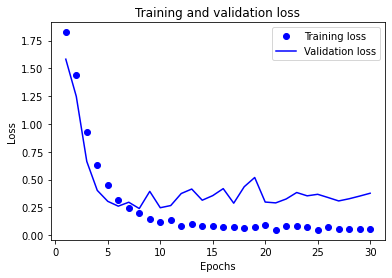

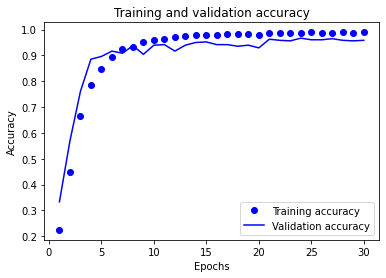

In [39]:
plot_loss(history_1_2)
plot_acc(history_1_2)

> This is an excellent model, giving peak validation accuracies of 96.67%, and looking at the graph above its extremely stable as well. This is the best model so far.

> **So the ideal model architecture is as shown in model_1_2, the ideal no. of epochs found is 30, and the ideal dropout rate for now is 0.5.**

---

*Highest Observed Validation Accuracy*: **96.67%**

---

## 2. Trying Global Max Pooling and layers.Flatten

> In this model, we will evaluate whether using Global Max Pooling or layer.Flatten works better than Global Average Pooling. So using the same best model from the previous section, the only layer that will be replaced will be the global average pooling layer.

### Using Maxpooling layer

In [41]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_2_1 = keras.Model(inputs, outputs)

model_2_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2_1.summary()

history_2_1 = model_2_1.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_28 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_260 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_261 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 conv2d_262 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                          

2022-08-31 01:16:21.338025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.8338 - accuracy: 0.1828

2022-08-31 01:16:33.610246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 15s 98ms/step - loss: 1.8338 - accuracy: 0.1828 - val_loss: 1.7923 - val_accuracy: 0.1667
Epoch 2/30
120/120 [==============================] - 11s 88ms/step - loss: 1.5171 - accuracy: 0.4148 - val_loss: 0.9957 - val_accuracy: 0.6063
Epoch 3/30
120/120 [==============================] - 11s 88ms/step - loss: 0.9138 - accuracy: 0.6555 - val_loss: 0.7101 - val_accuracy: 0.7417
Epoch 4/30
120/120 [==============================] - 11s 89ms/step - loss: 0.5873 - accuracy: 0.7789 - val_loss: 0.4172 - val_accuracy: 0.8521
Epoch 5/30
120/120 [==============================] - 11s 89ms/step - loss: 0.3720 - accuracy: 0.8633 - val_loss: 0.3434 - val_accuracy: 0.8917
Epoch 6/30
120/120 [==============================] - 11s 89ms/step - loss: 0.2554 - accuracy: 0.9125 - val_loss: 0.2712 - val_accuracy: 0.9146
Epoch 7/30
120/120 [==============================] - 11s 90ms/step - loss: 0.1785 - accuracy: 0.9391 - val_loss: 0.2897 - val_accuracy: 0.9208
Epo

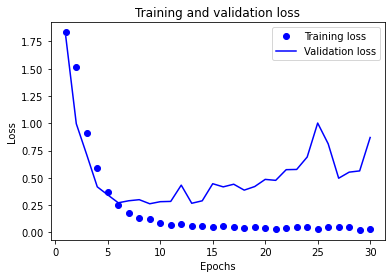

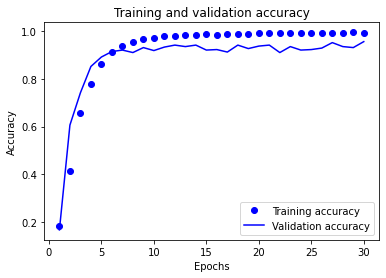

In [42]:
plot_loss(history_2_1)
plot_acc(history_2_1)

---

*Highest Observed Validation Accuracy*: **95.63%**

---

### Using Flatten

In [43]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_2_2 = keras.Model(inputs, outputs)

model_2_2.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2_2.summary()

history_2_2 = model_2_2.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_29 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_269 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_270 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 conv2d_271 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                          

2022-08-31 01:27:06.939051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.1708

2022-08-31 01:27:19.184015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 13s 96ms/step - loss: 1.8128 - accuracy: 0.1708 - val_loss: 1.7923 - val_accuracy: 0.1667
Epoch 2/30
120/120 [==============================] - 11s 94ms/step - loss: 1.7380 - accuracy: 0.2719 - val_loss: 1.1919 - val_accuracy: 0.5813
Epoch 3/30
120/120 [==============================] - 11s 91ms/step - loss: 0.9609 - accuracy: 0.6542 - val_loss: 0.5536 - val_accuracy: 0.8146
Epoch 4/30
120/120 [==============================] - 11s 92ms/step - loss: 0.4953 - accuracy: 0.8326 - val_loss: 0.3847 - val_accuracy: 0.8833
Epoch 5/30
120/120 [==============================] - 11s 91ms/step - loss: 0.2934 - accuracy: 0.9003 - val_loss: 0.3478 - val_accuracy: 0.8917
Epoch 6/30
120/120 [==============================] - 11s 92ms/step - loss: 0.1971 - accuracy: 0.9378 - val_loss: 0.3488 - val_accuracy: 0.8958
Epoch 7/30
120/120 [==============================] - 12s 97ms/step - loss: 0.1303 - accuracy: 0.9563 - val_loss: 0.3834 - val_accuracy: 0.9125
Epo

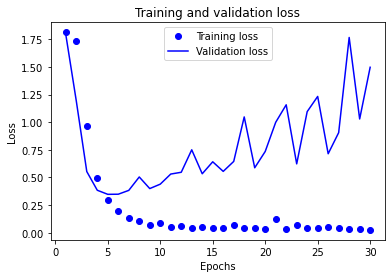

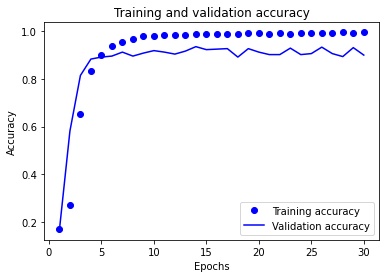

In [44]:
plot_loss(history_2_2)
plot_acc(history_2_2)

---

*Highest Observed Validation Accuracy*: **93.54%**

---

> Using global max pooling gave extremely similar results to average pooling as it gave validation accuracies of up to 95%, although average pooling was still better with peak validation accuracies of 96.67%. Using layer.Flatten gives much inferior results compared to the other two with peak validation accuracies not crossing 94%. 

> **So going forward, it makes sense to use global average pooling.**

## 3. Regularizing the model and testing different learning rates

> Regularizer and different learning rates

In [45]:
# adding l2 regularization
regularizer = keras.regularizers.L2(0.00002)

inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu', kernel_regularizer=regularizer)(x)
x = layers.Conv2D(256, 3, activation='relu', kernel_regularizer=regularizer)(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(6, activation='softmax')(x)

model_3_1 = keras.Model(inputs, outputs)

model_3_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3_1.summary()

history_3_1 = model_3_1.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_30 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_278 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_279 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 conv2d_280 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                          

2022-08-31 01:45:11.237125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.8313 - accuracy: 0.1935

2022-08-31 01:45:23.742652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 14s 97ms/step - loss: 1.8313 - accuracy: 0.1935 - val_loss: 1.7236 - val_accuracy: 0.2167
Epoch 2/30
120/120 [==============================] - 11s 93ms/step - loss: 1.6135 - accuracy: 0.3641 - val_loss: 1.1171 - val_accuracy: 0.5833
Epoch 3/30
120/120 [==============================] - 11s 93ms/step - loss: 1.1531 - accuracy: 0.5648 - val_loss: 0.9633 - val_accuracy: 0.6125
Epoch 4/30
120/120 [==============================] - 11s 92ms/step - loss: 0.8330 - accuracy: 0.7042 - val_loss: 0.6117 - val_accuracy: 0.7917
Epoch 5/30
120/120 [==============================] - 11s 93ms/step - loss: 0.5984 - accuracy: 0.7875 - val_loss: 0.5012 - val_accuracy: 0.8375
Epoch 6/30
120/120 [==============================] - 11s 93ms/step - loss: 0.4404 - accuracy: 0.8500 - val_loss: 0.3768 - val_accuracy: 0.8729
Epoch 7/30
120/120 [==============================] - 11s 96ms/step - loss: 0.3365 - accuracy: 0.8870 - val_loss: 0.3907 - val_accuracy: 0.8625
Epo

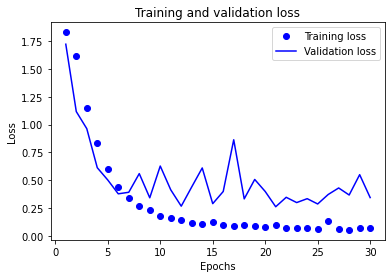

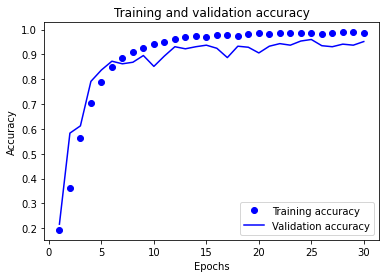

In [46]:
plot_loss(history_3_1)
plot_acc(history_3_1)

> Using an L2 regularizer with a value of 0.00002 for the last two Conv2D layer of size 256 gives quite good results and the model even crosses 96% validation accuracies, although not reaching the peak accuracy of 96.67% from section 1. So an extremely low regularizer value could be used in the best model. The ideal learning rate is found to be the default, 0.01. 

---

*Highest Observed Validation Accuracy*: **96.04%**

---

## 4. Adding residuals and batch normalization

> This is a new model which uses residuals and batch normalization to see if they help improve model performance. The architecture is quite similar to the best model so far, with the addition of two Conv2D layers of size 512 at the end. A regularizer is also included.

In [48]:
# The code below was inspired from the book Deep Learning with Python by Francois Chollet (Second Edition) Chapter 9, page 260. The original code is tweaked to work with a different model architecture from this project.

inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
regularizer = keras.regularizers.L2(0.00002)

x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  if size == 512:
    x = layers.Conv2D(size, 3, padding="same", use_bias=False, kernel_regularizer=regularizer)(x)  
  else:
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  if size == 512:
    x = layers.Conv2D(size, 3, padding="same", use_bias=False, kernel_regularizer=regularizer)(x)  
  else:
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_4_1 = keras.Model(inputs, outputs)

model_4_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4_1.summary()

history_4_1 = model_4_1.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_32 (Rescaling)       (None, 100, 100, 3)  0           ['input_35[0][0]']               
                                                                                                  
 conv2d_303 (Conv2D)            (None, 98, 98, 32)   864         ['rescaling_32[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 98, 98, 32)  128         ['conv2d_303[0][0]']      

2022-08-31 02:01:52.872243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 4.9677 - accuracy: 0.4073

2022-08-31 02:02:20.422110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 29s 216ms/step - loss: 4.9677 - accuracy: 0.4073 - val_loss: 7.0240 - val_accuracy: 0.1667
Epoch 2/30
120/120 [==============================] - 25s 209ms/step - loss: 1.4762 - accuracy: 0.6404 - val_loss: 5.0053 - val_accuracy: 0.1667
Epoch 3/30
120/120 [==============================] - 25s 209ms/step - loss: 0.8189 - accuracy: 0.7458 - val_loss: 4.6339 - val_accuracy: 0.2438
Epoch 4/30
120/120 [==============================] - 26s 215ms/step - loss: 0.5840 - accuracy: 0.8266 - val_loss: 1.9072 - val_accuracy: 0.5250
Epoch 5/30
120/120 [==============================] - 26s 219ms/step - loss: 0.4187 - accuracy: 0.8771 - val_loss: 0.7909 - val_accuracy: 0.7542
Epoch 6/30
120/120 [==============================] - 26s 219ms/step - loss: 0.2853 - accuracy: 0.9242 - val_loss: 1.1685 - val_accuracy: 0.7063
Epoch 7/30
120/120 [==============================] - 26s 220ms/step - loss: 0.2777 - accuracy: 0.9380 - val_loss: 1.0957 - val_accuracy: 0.7

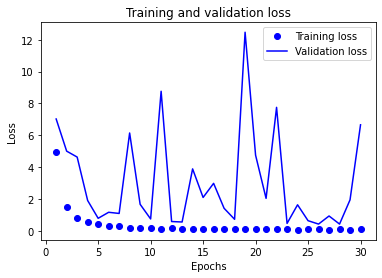

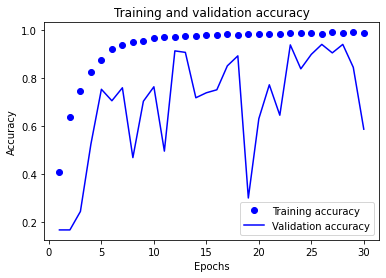

In [49]:
plot_loss(history_4_1)
plot_acc(history_4_1)

> While this model gives validation accuracies as high as around 94%, it is quite unstable in nature as apparent from the graphs above, and it also does not justify its huge size since it does not cross peak validation accuracies of the best model so far.

---

*Highest Observed Validation Accuracy*: **94.17%**

---

## 5. Experimenting with data augmentation

> In this section, the subject of experimentation will be data augmentation. A small model which gives extremely high validation accuracies is used as a benchmark to apply data augmentation and see if it helps. The learning rate will be increased to 0.009 and the number of epochs will be increased to 100, in order to compensate for data augmentation hindering faster overfitting. 

In [62]:
# Using this method for M1 Mac CPU acces to run augmentation
with tf.device('/cpu:0'):
  data_augmentation = keras.Sequential(
  [
      # Defining the augmentation params
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.2)
  ] 
  )

In [64]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
with tf.device('/cpu:0'):
  x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(6, activation='softmax')(x)

model_5_1 = keras.Model(inputs, outputs)

model_5_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_5_1.summary()

history_5_1 = model_5_1.fit(
  train,
  epochs=100,
  validation_data=val
)

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_43 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_384 (Conv2D)         (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 49, 49, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_385 (Conv2D)         (None, 47, 47, 32)        4640      
                                                          

2022-08-31 03:29:57.460652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


119/120 [============================>.] - ETA: 0s - loss: 1.7827 - accuracy: 0.1846

2022-08-31 03:30:04.255809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 8s 48ms/step - loss: 1.7822 - accuracy: 0.1852 - val_loss: 1.7504 - val_accuracy: 0.2500
Epoch 2/100
120/120 [==============================] - 6s 47ms/step - loss: 1.7101 - accuracy: 0.2607 - val_loss: 1.6656 - val_accuracy: 0.3271
Epoch 3/100
120/120 [==============================] - 5s 45ms/step - loss: 1.6439 - accuracy: 0.2995 - val_loss: 1.5730 - val_accuracy: 0.3896
Epoch 4/100
120/120 [==============================] - 5s 44ms/step - loss: 1.5794 - accuracy: 0.3367 - val_loss: 1.5069 - val_accuracy: 0.4146
Epoch 5/100
120/120 [==============================] - 5s 45ms/step - loss: 1.5263 - accuracy: 0.3693 - val_loss: 1.4605 - val_accuracy: 0.4208
Epoch 6/100
120/120 [==============================] - 5s 45ms/step - loss: 1.4765 - accuracy: 0.4029 - val_loss: 1.3678 - val_accuracy: 0.4917
Epoch 7/100
120/120 [==============================] - 5s 45ms/step - loss: 1.4242 - accuracy: 0.4305 - val_loss: 1.2789 - val_accuracy: 0.5125
Epoc

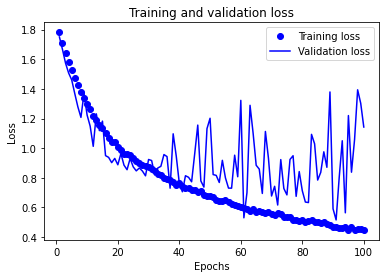

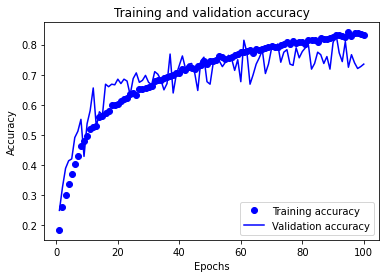

In [65]:
plot_loss(history_5_1)
plot_acc(history_5_1)

> Using data augmentation causes the training accuracy to rise at a very slow rate, and increasing the number of epochs and learning rate does not help much. So while data augmentation did work and trains the model well, we would have to run that model for many epochs which is redundant for the scope of this project.

---

*Highest Observed Validation Accuracy*: **84.11%**

---

## 6. Experimenting with image processing

> In this section, the subject of experimentation is the use of image processing. Essentially, images from the train, validation, and test set will be processed, and then the processed images will be trained and tested on.

In [67]:
# Creating new modified train, test and val datasets after applying image processing

def process_image(x):
  x = tf.image.adjust_brightness(x, 0.8)
  x = tf.image.adjust_contrast(x, 3)
  x = tf.image.adjust_saturation(x, 2)
  return x

def process_ds(dataset):
  return dataset.map(lambda x, y: (process_image(x), y)).prefetch(tf.data.AUTOTUNE).cache()
  
train_processed = process_ds(train)
val_processed = process_ds(val)
test_processed = process_ds(test)

### Trying processed images on the best model so far

In [68]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizer)(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizer)(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizer)(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_6_2 = keras.Model(inputs, outputs)

model_6_2.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_6_2.summary()

history_6_2 = model_6_2.fit(
  train_processed,
  epochs=40,
  validation_data=val_processed
)

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_44 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_388 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_389 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 conv2d_390 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 47, 47, 32)       0         
 ng2D)                                                           
                                                          

2022-08-31 03:41:12.753681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.6455 - accuracy: 0.3273

2022-08-31 03:41:26.353376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 15s 100ms/step - loss: 1.6455 - accuracy: 0.3273 - val_loss: 1.0259 - val_accuracy: 0.6000
Epoch 2/40
120/120 [==============================] - 11s 93ms/step - loss: 0.9639 - accuracy: 0.6388 - val_loss: 0.9422 - val_accuracy: 0.6625
Epoch 3/40
120/120 [==============================] - 11s 94ms/step - loss: 0.6181 - accuracy: 0.7844 - val_loss: 0.3886 - val_accuracy: 0.8583
Epoch 4/40
120/120 [==============================] - 12s 96ms/step - loss: 0.4295 - accuracy: 0.8534 - val_loss: 0.3275 - val_accuracy: 0.8792
Epoch 5/40
120/120 [==============================] - 12s 97ms/step - loss: 0.3055 - accuracy: 0.9021 - val_loss: 0.2896 - val_accuracy: 0.9021
Epoch 6/40
120/120 [==============================] - 12s 100ms/step - loss: 0.2161 - accuracy: 0.9289 - val_loss: 0.2564 - val_accuracy: 0.9250
Epoch 7/40
120/120 [==============================] - 12s 103ms/step - loss: 0.1900 - accuracy: 0.9435 - val_loss: 0.3531 - val_accuracy: 0.8958


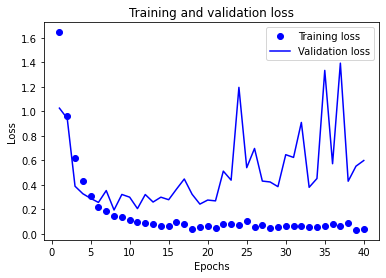

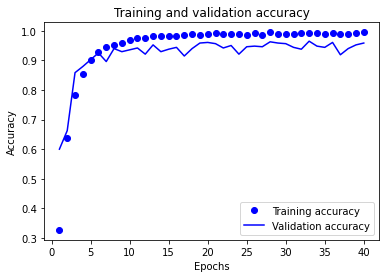

In [69]:
plot_loss(history_6_2)
plot_acc(history_6_2)

> This model reaches peak accuracy of around 96% just like the best model, and it is similarly slightly as can be from the graphs above. 

---

*Highest Observed Validation Accuracy*: **96.46%**

---

## 7. Efficient model - the highest possible accuracy with the lowest possible size

> This idea in this section is to use the small benchmark model from section 5 of data augmentation, and tweak it in order to maximize accuracy.

In [70]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_7_1 = keras.Model(inputs, outputs)

model_7_1.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_7_1.summary()

history_7_1 = model_7_1.fit(
  train,
  epochs=30,
  validation_data=val
)

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_397 (Conv2D)         (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 49, 49, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_398 (Conv2D)         (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 23, 23, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_399 (Conv2D)         (None, 21, 21, 32)        924

2022-08-31 03:52:57.271594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 2.6164 - accuracy: 0.1935

2022-08-31 03:53:01.764921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 5s 29ms/step - loss: 2.6164 - accuracy: 0.1935 - val_loss: 1.7757 - val_accuracy: 0.3250
Epoch 2/30
120/120 [==============================] - 3s 25ms/step - loss: 1.7999 - accuracy: 0.2065 - val_loss: 1.7489 - val_accuracy: 0.2167
Epoch 3/30
120/120 [==============================] - 3s 23ms/step - loss: 1.7437 - accuracy: 0.2773 - val_loss: 1.8174 - val_accuracy: 0.2021
Epoch 4/30
120/120 [==============================] - 3s 24ms/step - loss: 1.6351 - accuracy: 0.3292 - val_loss: 1.8224 - val_accuracy: 0.2396
Epoch 5/30
120/120 [==============================] - 3s 24ms/step - loss: 1.5136 - accuracy: 0.3734 - val_loss: 1.3680 - val_accuracy: 0.5312
Epoch 6/30
120/120 [==============================] - 3s 24ms/step - loss: 1.4061 - accuracy: 0.4492 - val_loss: 1.1832 - val_accuracy: 0.6542
Epoch 7/30
120/120 [==============================] - 3s 25ms/step - loss: 1.2658 - accuracy: 0.5094 - val_loss: 0.9924 - val_accuracy: 0.7000
Epoch 8/30

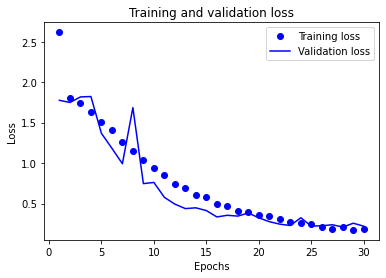

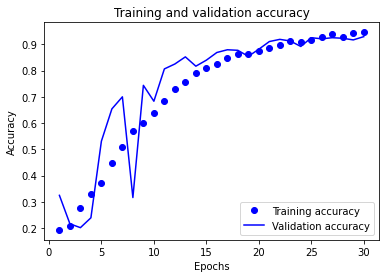

In [71]:
plot_loss(history_7_1)
plot_acc(history_7_1)

> Reaching peak validation accuracies of around 92% with just 23000 parameters, this is clearly the most efficient model in terms to the parameters to accuracy ratio.

---

*Highest Observed Validation Accuracy*: **92.92%**

---